For fine-tuning we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script"

In [5]:
!mkdir -p $result_dir

In [34]:
# load hdf5 files and extract columns
#train_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset.h5', 'r')
#holdout_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset.h5', 'r')

train_h5 = h5py.File('/analysis/ritter/Dataset/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/ritter/Dataset/MS/CIS/holdout_dataset.h5', 'r')


X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [35]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [36]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [37]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [38]:
mask = None

In [39]:
intensity = IntensityRescale(masked=False)

In [40]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


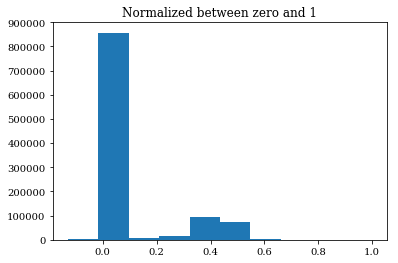

In [41]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


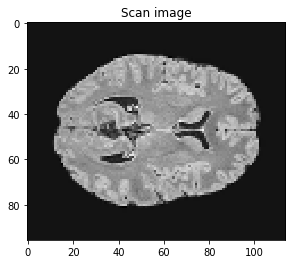

In [16]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

# Model

In [17]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [24]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
#model_path = "/analysis/ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
model_path = "/analysis/fabiane/models/ADNI/explMS/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [25]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [26]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [27]:
def reset_weights(model):
    # Note this only used for visualization below
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


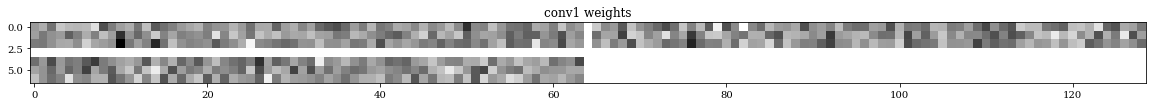

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean 0.0007953853928484023


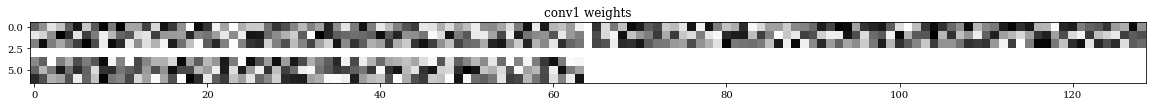

In [28]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

## Training

In [ ]:
X_train.shape

In [ ]:
from sklearn.model_selection import train_test_split

In [42]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

NameError: name 'train_test_split' is not defined

Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


27/27 [==============================] - 8s 297ms/step - loss: 1.0339 - acc: 0.5273 - val_loss: 0.8904 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 153ms/step - loss: 0.9515 - acc: 0.4810 - val_loss: 0.8901 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 5s 167ms/step - loss: 0.9102 - acc: 0.5273 - val_loss: 0.8702 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 154ms/step - loss: 0.8622 - acc: 0.5283 - val_loss: 0.8118 - val_acc: 0.6842

Epoch 00004: val_acc improved from 0.68421 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial0-improvement-BEST.hdf5
Epoch 5/200
27/27 [======

27/27 [==============================] - 4s 155ms/step - loss: 0.3088 - acc: 0.9722 - val_loss: 0.4180 - val_acc: 0.9474

Epoch 00042: val_acc did not improve from 0.94737
Epoch 43/200
27/27 [==============================] - 4s 165ms/step - loss: 0.3549 - acc: 0.9083 - val_loss: 0.4136 - val_acc: 0.9474

Epoch 00043: val_acc did not improve from 0.94737
Epoch 44/200
27/27 [==============================] - 4s 164ms/step - loss: 0.3003 - acc: 0.9629 - val_loss: 0.4187 - val_acc: 0.9474

Epoch 00044: val_acc did not improve from 0.94737
Epoch 45/200
27/27 [==============================] - 5s 171ms/step - loss: 0.3241 - acc: 0.9537 - val_loss: 0.4389 - val_acc: 0.9474

Epoch 00045: val_acc did not improve from 0.94737
Epoch 46/200
27/27 [==============================] - 4s 166ms/step - loss: 0.3246 - acc: 0.9166 - val_loss: 0.3800 - val_acc: 0.9474

Epoch 00046: val_acc did not improve from 0.94737
Epoch 47/200
27/27 [==============================] - 5s 167ms/step - loss: 0.2954 - acc

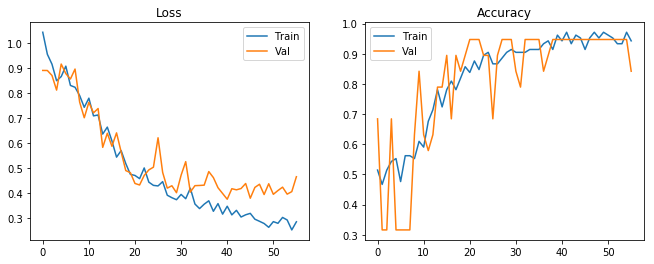

Trial 1
Epoch 1/200
27/27 [==============================] - 6s 210ms/step - loss: 1.0789 - acc: 0.4912 - val_loss: 0.9427 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial1-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 156ms/step - loss: 0.9999 - acc: 0.3800 - val_loss: 0.8852 - val_acc: 0.7368

Epoch 00002: val_acc improved from 0.31579 to 0.73684, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial1-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 165ms/step - loss: 0.9325 - acc: 0.5654 - val_loss: 0.8774 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.73684
Epoch 4/200
27/27 [==============================] - 4s 167ms/step - loss: 0.9597 - acc: 0.4634 - val_loss: 0.8633 - val_acc: 0.3684

Epoch 00004: val_acc did not improve from 0.73684
Epoch


Epoch 00040: val_acc did not improve from 0.94737
Epoch 41/200
27/27 [==============================] - 5s 169ms/step - loss: 0.3142 - acc: 0.9259 - val_loss: 0.4321 - val_acc: 0.9474

Epoch 00041: val_acc did not improve from 0.94737
Epoch 42/200
27/27 [==============================] - 5s 179ms/step - loss: 0.2885 - acc: 0.9629 - val_loss: 0.3980 - val_acc: 0.9474

Epoch 00042: val_acc did not improve from 0.94737
Epoch 43/200
27/27 [==============================] - 4s 162ms/step - loss: 0.3406 - acc: 0.9351 - val_loss: 0.4363 - val_acc: 0.9474

Epoch 00043: val_acc did not improve from 0.94737
Epoch 44/200
27/27 [==============================] - 5s 168ms/step - loss: 0.3232 - acc: 0.9444 - val_loss: 0.4228 - val_acc: 0.9474

Epoch 00044: val_acc did not improve from 0.94737
Epoch 45/200
27/27 [==============================] - 5s 178ms/step - loss: 0.2780 - acc: 0.9537 - val_loss: 0.4031 - val_acc: 0.9474

Epoch 00045: val_acc did not improve from 0.94737
Epoch 46/200
27/27 [====

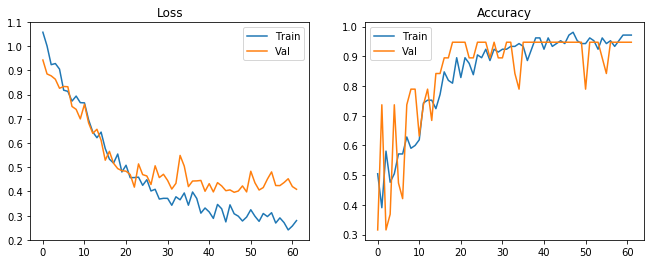

Trial 2
Epoch 1/200
27/27 [==============================] - 5s 199ms/step - loss: 1.1229 - acc: 0.4542 - val_loss: 0.8734 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial2-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 156ms/step - loss: 0.9512 - acc: 0.4542 - val_loss: 0.9042 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 165ms/step - loss: 0.9730 - acc: 0.4356 - val_loss: 0.8700 - val_acc: 0.6316

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 159ms/step - loss: 0.8799 - acc: 0.5273 - val_loss: 0.9165 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 164ms/step - loss: 0.8609 - acc: 0.5561 - val_loss: 0.8017 - val_acc: 0.6842

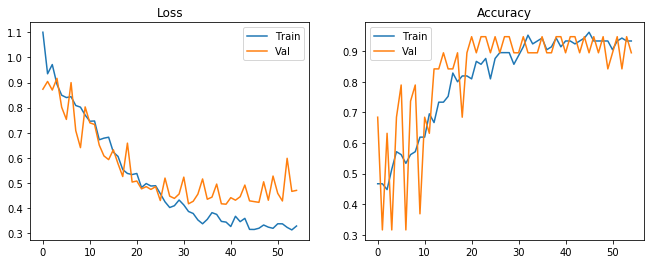

Trial 3
Epoch 1/200
27/27 [==============================] - 6s 215ms/step - loss: 0.9688 - acc: 0.5376 - val_loss: 1.0263 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial3-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 156ms/step - loss: 0.9790 - acc: 0.4810 - val_loss: 0.9514 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.9084 - acc: 0.5551 - val_loss: 0.9069 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 4s 161ms/step - loss: 0.8819 - acc: 0.4912 - val_loss: 0.8681 - val_acc: 0.4737

Epoch 00004: val_acc improved from 0.31579 to 0.47368, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial3-improvement-BEST.hdf5
Epoch

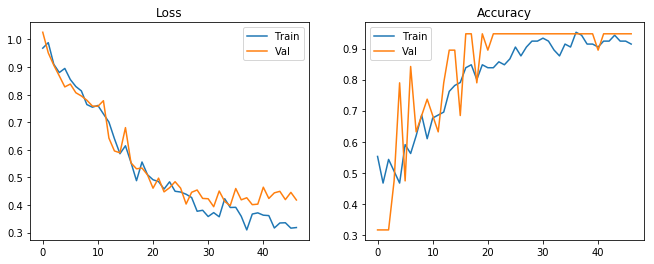

Trial 4
Epoch 1/200
27/27 [==============================] - 6s 216ms/step - loss: 1.0818 - acc: 0.5190 - val_loss: 1.3649 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial4-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 154ms/step - loss: 0.9689 - acc: 0.4902 - val_loss: 1.0009 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.9444 - acc: 0.4634 - val_loss: 0.8600 - val_acc: 0.6842

Epoch 00003: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial4-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 152ms/step - loss: 0.8728 - acc: 0.5458 - val_loss: 0.9357 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch

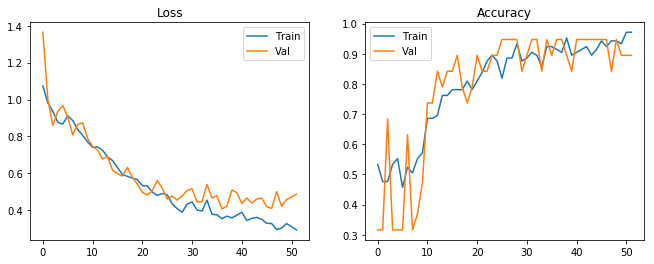

Trial 5
Epoch 1/200
27/27 [==============================] - 6s 214ms/step - loss: 1.0274 - acc: 0.4634 - val_loss: 0.8589 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial5-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 161ms/step - loss: 0.9004 - acc: 0.5932 - val_loss: 1.0389 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 160ms/step - loss: 0.9850 - acc: 0.3986 - val_loss: 1.1855 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 165ms/step - loss: 0.9144 - acc: 0.5366 - val_loss: 0.9336 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 161ms/step - loss: 0.8769 - acc: 0.5098 - val_loss: 0.8686 - val_acc: 0.3684

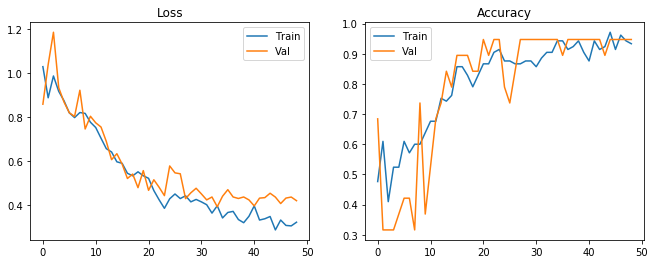

Trial 6
Epoch 1/200
27/27 [==============================] - 6s 220ms/step - loss: 1.0637 - acc: 0.5273 - val_loss: 0.8491 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial6-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9590 - acc: 0.4902 - val_loss: 1.0038 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 5s 170ms/step - loss: 0.9772 - acc: 0.4717 - val_loss: 0.8925 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 164ms/step - loss: 0.9503 - acc: 0.4449 - val_loss: 0.8741 - val_acc: 0.2632

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 159ms/step - loss: 0.8713 - acc: 0.4717 - val_loss: 0.8573 - val_acc: 0.3158

27/27 [==============================] - 4s 165ms/step - loss: 0.3344 - acc: 0.9259 - val_loss: 0.4708 - val_acc: 0.8947

Epoch 00042: val_acc did not improve from 0.94737
Epoch 43/200
27/27 [==============================] - 4s 157ms/step - loss: 0.3354 - acc: 0.9166 - val_loss: 0.4897 - val_acc: 0.7895

Epoch 00043: val_acc did not improve from 0.94737
Epoch 44/200
27/27 [==============================] - 5s 167ms/step - loss: 0.3166 - acc: 0.9537 - val_loss: 0.4247 - val_acc: 0.9474

Epoch 00044: val_acc did not improve from 0.94737
Epoch 45/200
27/27 [==============================] - 4s 160ms/step - loss: 0.3802 - acc: 0.8980 - val_loss: 0.4214 - val_acc: 0.9474

Epoch 00045: val_acc did not improve from 0.94737
Epoch 46/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3027 - acc: 0.9351 - val_loss: 0.4677 - val_acc: 0.8947

Epoch 00046: val_acc did not improve from 0.94737
Epoch 47/200
27/27 [==============================] - 4s 165ms/step - loss: 0.3390 - acc

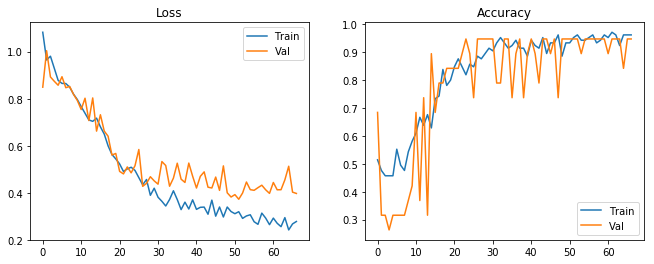

Trial 7
Epoch 1/200
27/27 [==============================] - 6s 229ms/step - loss: 1.0281 - acc: 0.5190 - val_loss: 0.9419 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial7-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9398 - acc: 0.5644 - val_loss: 0.8735 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial7-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 160ms/step - loss: 0.9204 - acc: 0.4810 - val_loss: 0.8962 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 161ms/step - loss: 0.8911 - acc: 0.5088 - val_loss: 1.0685 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch

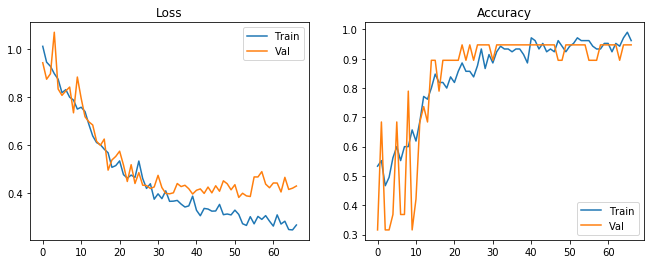

Trial 8
Epoch 1/200
27/27 [==============================] - 6s 239ms/step - loss: 1.0045 - acc: 0.5098 - val_loss: 0.9906 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial8-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 153ms/step - loss: 0.9422 - acc: 0.4912 - val_loss: 0.8805 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial8-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 160ms/step - loss: 0.8669 - acc: 0.5829 - val_loss: 0.9292 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 153ms/step - loss: 0.8601 - acc: 0.5922 - val_loss: 0.8611 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch


Epoch 00042: val_acc did not improve from 0.94737
Epoch 43/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3190 - acc: 0.9444 - val_loss: 0.3737 - val_acc: 0.9474

Epoch 00043: val_acc did not improve from 0.94737
Epoch 44/200
27/27 [==============================] - 4s 163ms/step - loss: 0.3020 - acc: 0.9722 - val_loss: 0.3877 - val_acc: 0.9474

Epoch 00044: val_acc did not improve from 0.94737
Epoch 45/200
27/27 [==============================] - 4s 157ms/step - loss: 0.3307 - acc: 0.9351 - val_loss: 0.4059 - val_acc: 0.9474

Epoch 00045: val_acc did not improve from 0.94737
Epoch 46/200
27/27 [==============================] - 4s 165ms/step - loss: 0.2789 - acc: 0.9537 - val_loss: 0.4325 - val_acc: 0.9474

Epoch 00046: val_acc did not improve from 0.94737
Epoch 47/200
27/27 [==============================] - 4s 160ms/step - loss: 0.3095 - acc: 0.9537 - val_loss: 0.4259 - val_acc: 0.9474

Epoch 00047: val_acc did not improve from 0.94737
Epoch 48/200
27/27 [====

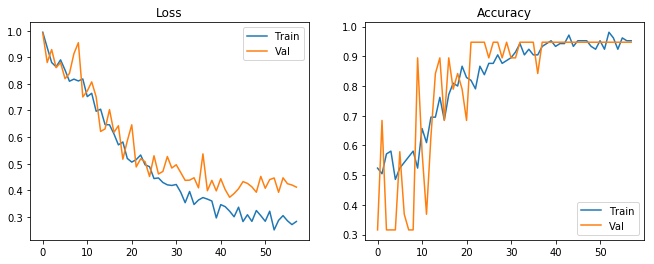

Trial 9
Epoch 1/200
27/27 [==============================] - 7s 245ms/step - loss: 0.9800 - acc: 0.5180 - val_loss: 0.9562 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial9-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9890 - acc: 0.4634 - val_loss: 0.9030 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 161ms/step - loss: 0.9219 - acc: 0.5273 - val_loss: 0.8394 - val_acc: 0.6842

Epoch 00003: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial9-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 5s 171ms/step - loss: 0.8821 - acc: 0.4912 - val_loss: 0.8425 - val_acc: 0.6316

Epoch 00004: val_acc did not improve from 0.68421
Epoch

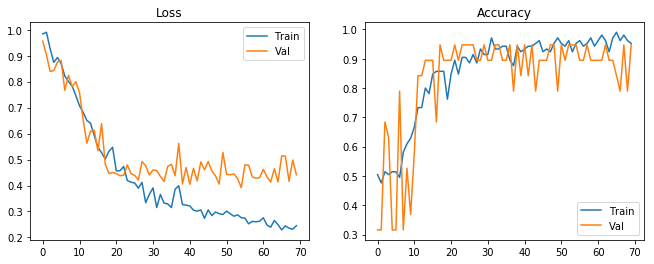

Training Time: 0.0h:44.0m:12.01481556892395s
Validation final accuracies: 
 [0.8421052631578947, 0.9473684210526315, 0.8947368421052632, 0.9473684210526315, 0.8947368421052632, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315]
Validation final accuracies mean: 0.9263157894736842
Validation best accuracies: 
 [0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315]
Validation best accuracies mean: 0.9473684210526315
Validation balanced accuracies: 
 [0.8397435897435898, 0.9166666666666667, 0.8782051282051282, 0.9166666666666667, 0.8333333333333333, 0.9166666666666667, 0.9166666666666667, 0.9166666666666667, 0.9166666666666667, 0.9166666666666667]
Validation balanced accuracies mean: 0.8967948717948717
Validation final sensitivities: 
 [0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0

In [24]:
# training args
lr = 0.0005
lr_decay = 0.002
transforms = [intensity, sagittal_flip, translate]

num_trials = 10
store_models = True

accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = init_model(model_path, finetune=False, up_to=None)    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=4, shuffle=False)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        validation_data=val_loader,
                        callbacks=callbacks)
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))
    sensitivities.append(sens)
    specificities.append(spec)

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(sensitivities)))
print("Validation final specificities: \n {}".format(specificities))
print("Validation final specificities' mean: {}".format(np.mean(specificities)))

In [25]:
training_time = time.time() - start_time

# Evaluation

In [43]:
lr = 0.0005
lr_decay = 0.002
num_trials = 10

In [44]:
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [45]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False)

In [57]:
plt.rc('font', family='serif')
#file_path = None
image_file_dir = "/analysis/fabiane/documents/publications/MS_CNN_VIS/"
file_path = os.path.join(image_file_dir, "fine_tuning_MS_ROC_curve.png")

Fold 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 91.30 %
Balanced accuracy 91.15 %
Sensitivity 92.31 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Fold 1


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 86.15 %
Sensitivity 92.31 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Fold 2


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 86.15 %
Sensitivity 92.31 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 96.92
Fold 3


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 97.69
Fold 4


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 86.15 %
Sensitivity 92.31 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 96.92
Fold 5


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 91.30 %
Balanced accuracy 91.15 %
Sensitivity 92.31 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 95.38
Fold 6


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 86.15 %
Sensitivity 92.31 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 95.38
Fold 7


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 86.15 %
Sensitivity 92.31 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 96.92
Fold 8


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 86.15 %
Sensitivity 92.31 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 96.15
Fold 9


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 86.96 %
Balanced accuracy 86.15 %
Sensitivity 92.31 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 96.15
######## Final results ########
Accuracy mean 87.83 %
Balanced accuracy mean 87.04 %
Sensitivity mean 93.08 %
Specificity mean 81.00 %
Mean ROC AUC score 96.08


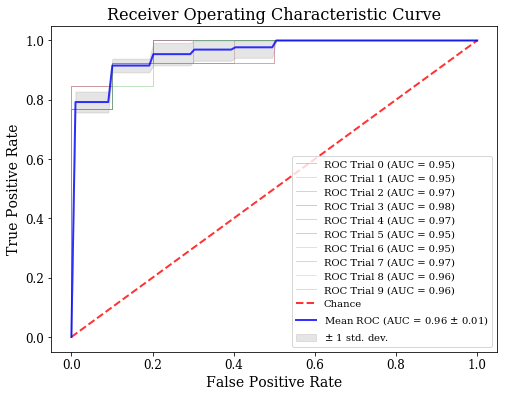

In [60]:
accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = load_model(model_path)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Evaluate
    res = model.evaluate_generator(test_loader)
    y_pred = model.predict_generator(test_loader)
    bal_acc = balanced_accuracy(y_holdout, y_pred>0.5)
    sens = sensitivity(y_holdout, y_pred>0.5)
    spec = specificity(y_holdout, y_pred>0.5)
    roc_auc = roc_auc_score(y_holdout, y_pred)
    fpr, tpr, thresholds = roc_curve(y_holdout, y_pred)   
    # Store results
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
    sensitivities.append(sens)
    specificities.append(spec)
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation
    # Print results
    print("Model accuracy {:.2f} %".format(res[1]*100))
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    print("Sensitivity {:.2f} %".format(sens*100))
    print("Specificity {:.2f} %".format(spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC Trial %d (AUC = %0.2f)' % (fold, roc_auc))
    
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))
print("Sensitivity mean {:.2f} %".format(np.mean(sensitivities)*100))
print("Specificity mean {:.2f} %".format(np.mean(specificities)*100))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.title('Receiver Operating Characteristic Curve', fontsize=16)
plt.legend(loc="lower right")
if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
plt.show()

In [29]:
total_time = time.time() - start_time

In [30]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 0.0h:44.0m:12.027180671691895s
Total time elapsed: 0.0h:45.0m:56.69809341430664s


In [31]:
quit()